In [1]:
import json
import os

import networkx as nx
import matplotlib.pyplot as plt

from taar_lite.recommenders.guidguid import GuidGuidCoinstallRecommender
from taar_lite.recommenders.treatments import MinInstallPrune, RowNormSum

In [2]:
DATA_DIR = os.environ.get('DATA_DIR')

# Under my data directory, I have a directory called taar-lite-s3 that I populated with
#  $ aws s3 sync s3://telemetry-parquet/taar/lite taar-lite-s3

input_dict_path = os.path.join(DATA_DIR, 'taar-lite-s3', 'guid_coinstallation.json')
ranking_dict_path = os.path.join(DATA_DIR, 'taar-lite-s3', 'guid_install_ranking.json')

In [3]:
with open(input_dict_path, 'r') as f:
    input_dict = json.loads(f.read())
with open(ranking_dict_path, 'r') as f:
    ranking_dict = json.loads(f.read())

recommender = GuidGuidCoinstallRecommender(
    raw_coinstall_dict=input_dict, 
    treatment_kwargs={
        'ranking_dict': ranking_dict
    },
    treatments=[MinInstallPrune(), RowNormSum()]
)

## Build and visualize the treated graph

In [14]:
treatment_graph = nx.DiGraph()
for guid, coinstall_rankings in recommender.treated_graph.items():
    for co_guid, ranking in coinstall_rankings.items():
        treatment_graph.add_edge(guid, co_guid, weight=ranking)

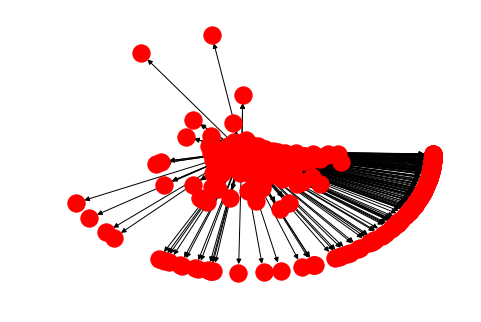

In [13]:
nx.draw_kamada_kawai(treatment_graph)

<small>Oh dear - this viz took over 2 hours to compute, and looks terrible. Maybe don't do this on treatment graphs.</small>

In [18]:
def draw_graph(G):
    plt.figure(3,figsize=(20,20)) 
    nx.draw_spring(
        G,
        edge_color='gray',
        width=0.1,
        alpha=0.5,
        node_color='gray',
        node_size=10,
        arrows=False,
        random_state=11,
        scale=2,
        k=0.4
    )
    plt.show()
    
def print_stats(G):
    print("Number of nodes: {:,}".format(G.number_of_nodes()))
    print("Number of edges: {:,}".format(G.number_of_edges()))

In [19]:
print_stats(treatment_graph)

Number of nodes: 3,999
Number of edges: 297,334


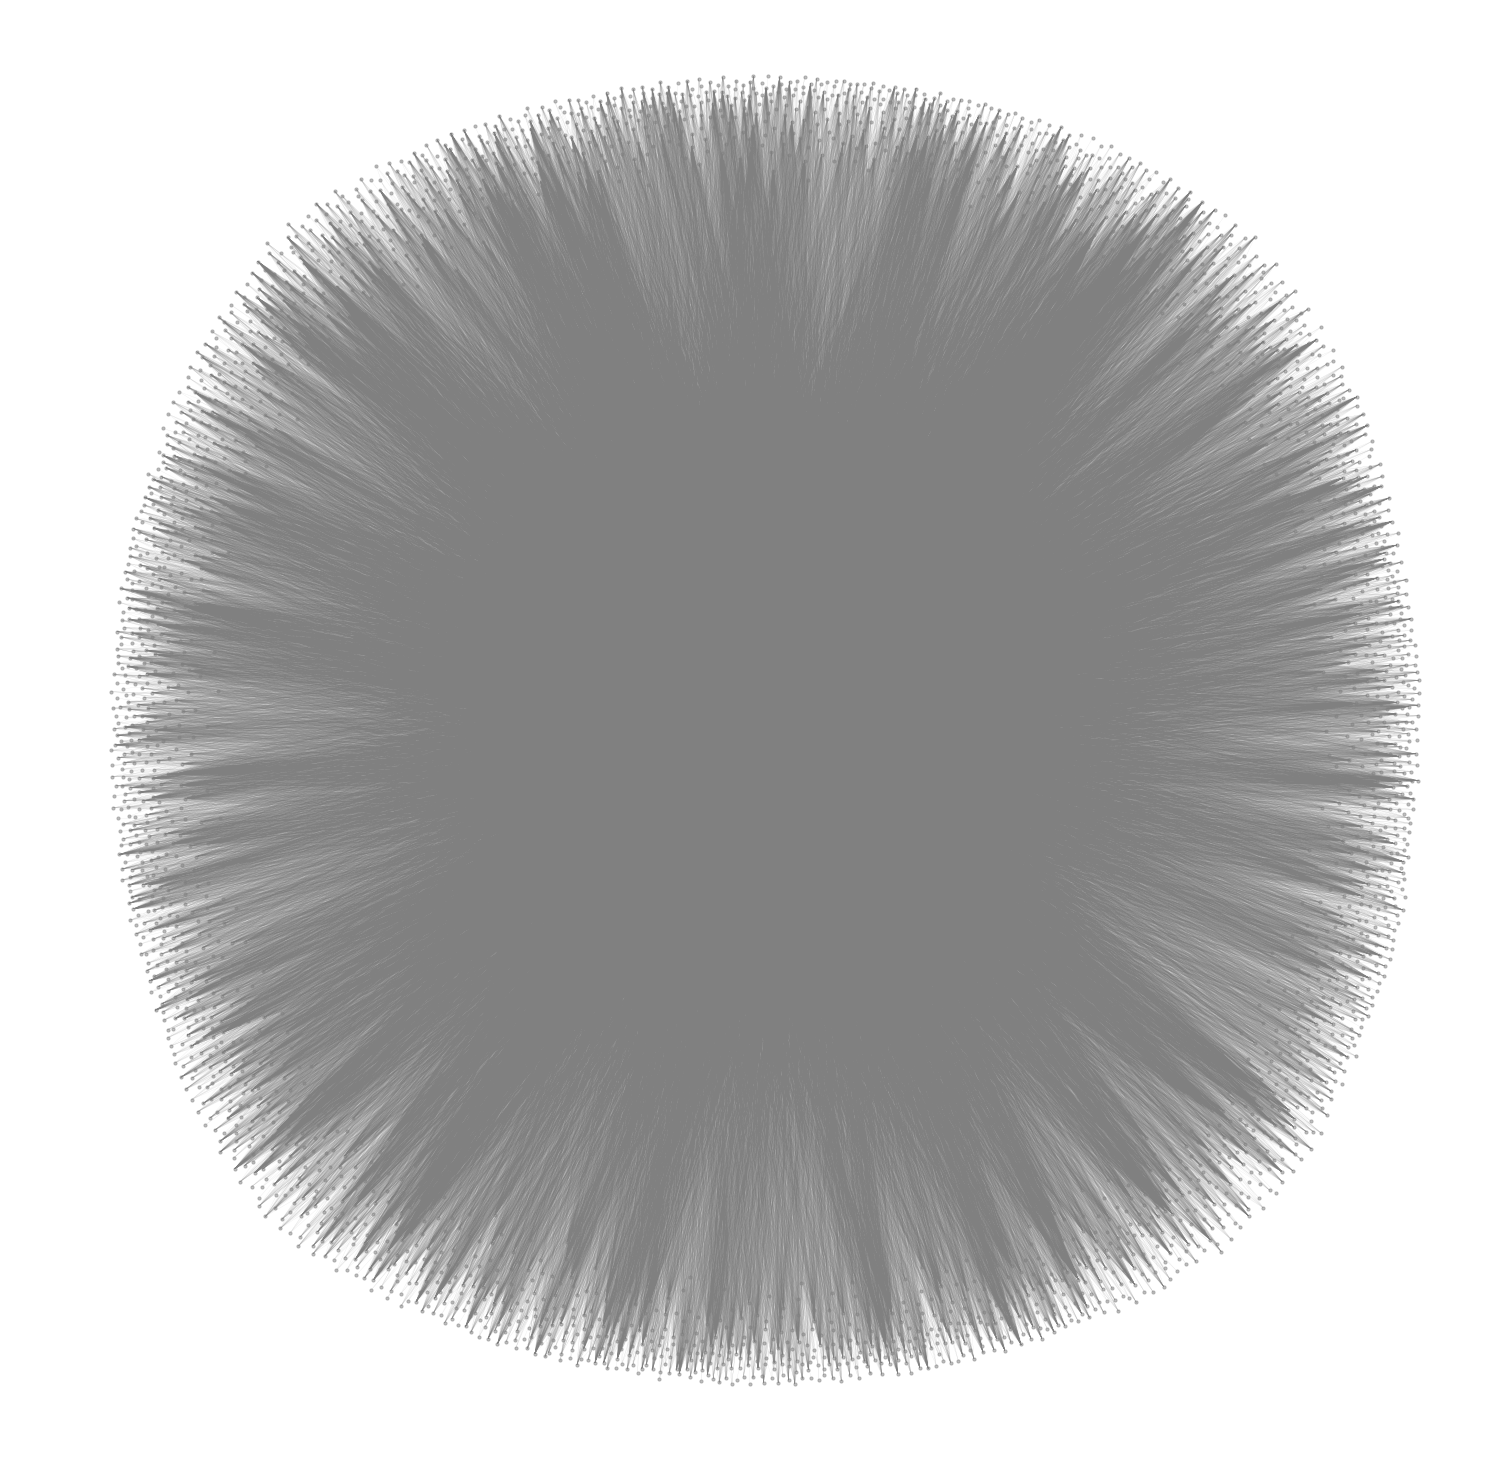

In [15]:
draw_graph(treatment_graph)

## Build and visualize the recommendation graph

In [4]:
recommendation_graph = nx.DiGraph()
for guid, recommendation_list in recommender.get_recommendation_graph(limit=4).items():
    for rec in recommendation_list:
        recommendation_graph.add_edge(guid, rec[0])

In [20]:
print_stats(recommendation_graph)

Number of nodes: 2,508
Number of edges: 2,720


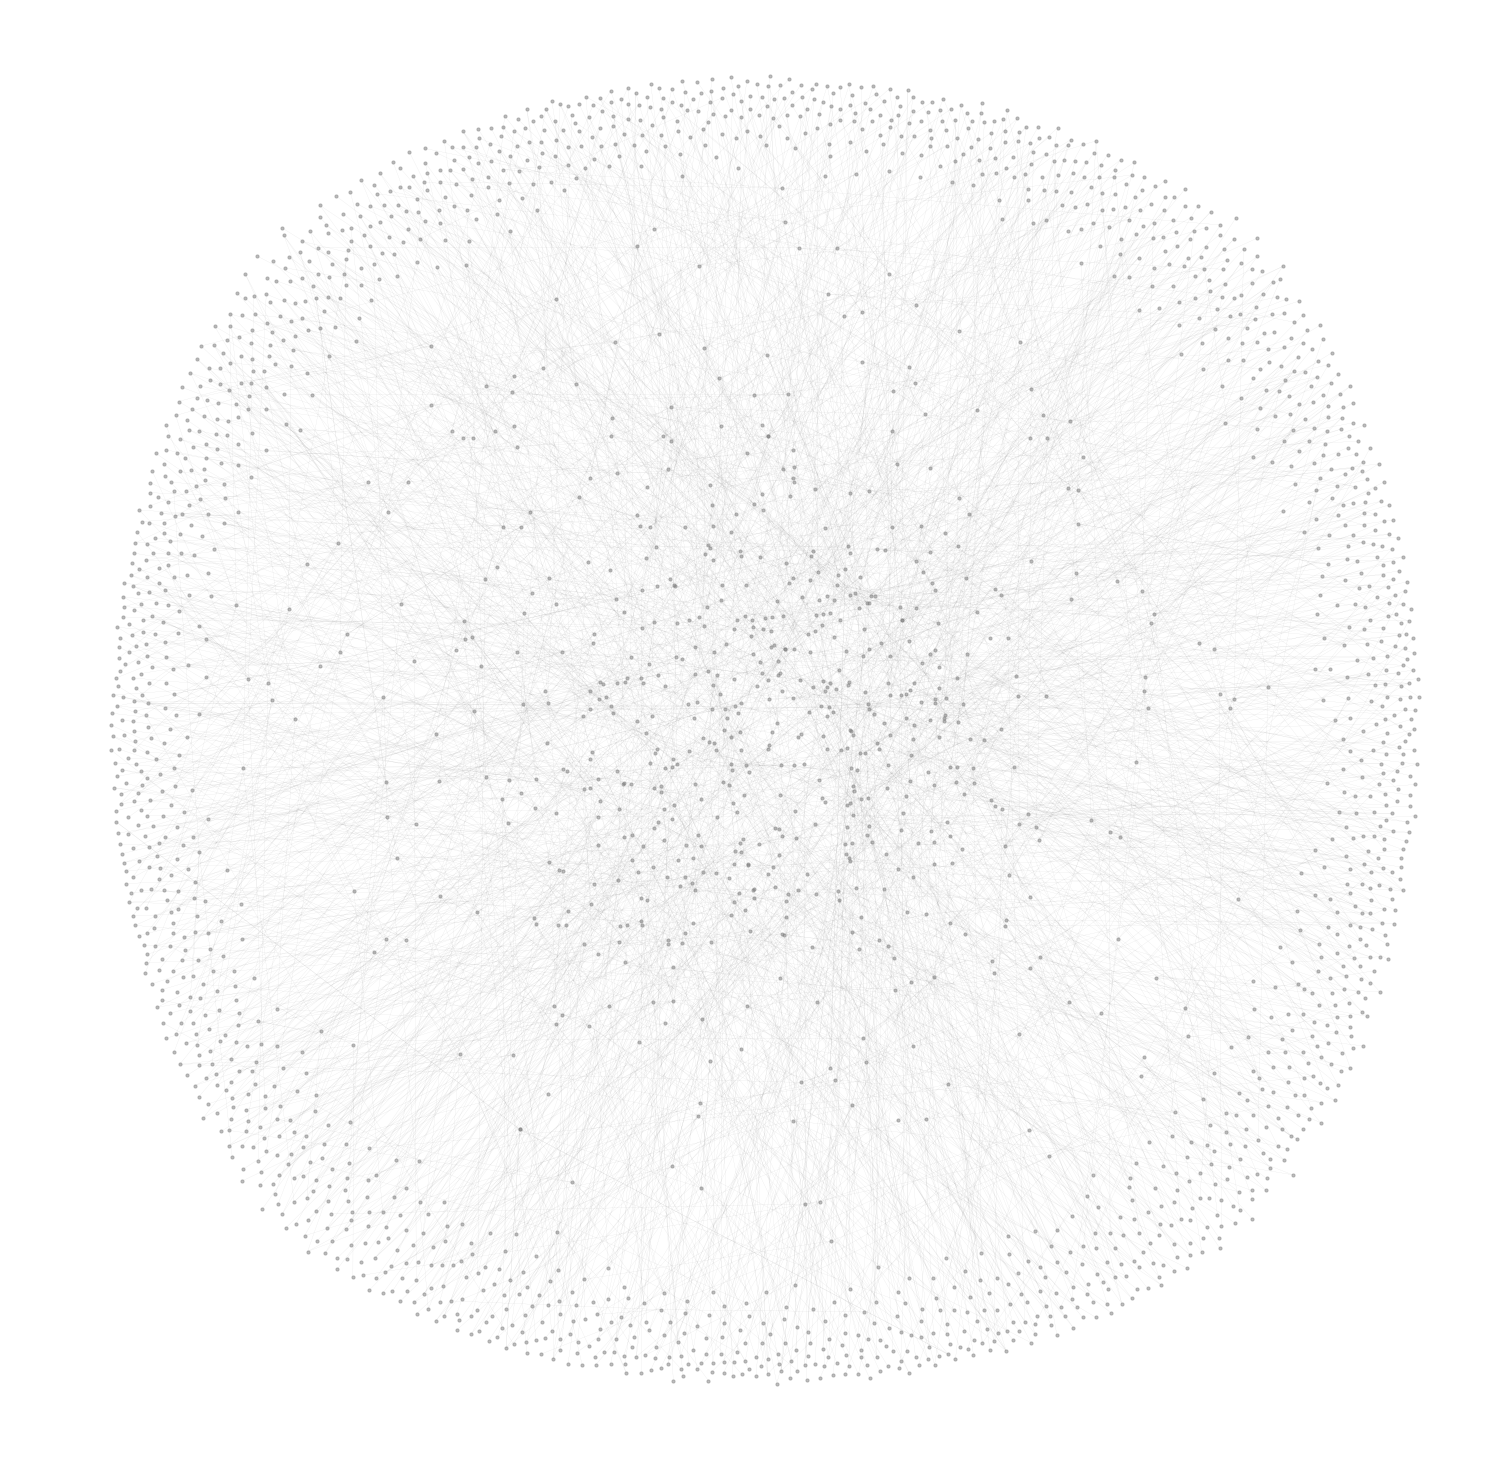

In [12]:
draw_graph(recommendation_graph)

## Questions

1. Do we understand why the number of nodes has dropped off by 1500?
1. Where does whitelisting haapen? (It's not in this taar-lite library, but I have it in some of our earlier analysis work. Has the coinstallation graph already been pushed through the whitelisting filter?